<a href="https://colab.research.google.com/github/Masoomas98/DSPS_MSarfraz/blob/main/lab/Lab_01_12_CNNgalaxies_classify_tofillin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pylab as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback

In [3]:
#keras layers I will need
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [4]:
#keras functions for training
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LambdaCallback # to create callbacks on the fly (I wont use it but just so you know it exists)


# Read in data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/Shareddrives/DSPS/

/content/drive/Shareddrives/DSPS


In [9]:
ls

10802534_761689917241346_821292660_n.jpg  galaxies.npy
ak0.png                                   galaxy-zoo-the-galaxy-challenge.zip
ak1.png                                   galcheckpoints/
ak2.png                                   higgsb/
ak3.png                                   images_training_rev1/
ak4.png                                   imgreconstruct_10000.h5
all_ones_benchmark.zip                    kaggleTitanic/
all_zeros_benchmark.zip                   nyzipcodes/
central_pixel_benchmark.zip               training_solutions_rev1.csv
checkpoint                                training_solutions_rev1_short.csv
checkpointConv..data-00000-of-00001       training_solutions_rev1.zip
checkpointConv..index                     uo_img.jpg
data/


In [21]:
ims = np.load("galaxies.npy")


In [22]:
ims.shape

(1000, 424, 424, 3)

In [17]:
ims = pd.read_csv("training_solutions_rev1_short.csv", sep=',')

In [31]:
ims.dtype

dtype('uint8')

In [32]:
ims = ims[:,::2,::2,:] #subsample original data cause we have limited RAM (eevery other pixel)
ims.shape

(1000, 212, 212, 3)

In [23]:
# read in the labels
training_labels2 = pd.read_csv("training_solutions_rev1_short.csv").iloc[:1000]
training_labels2.head(10)

,nga,spi,ell,irr
0,0.000000,0.512101,0.945547,0.027227
1,0.009222,0.236781,0.810851,0.140353
2,0.056931,0.117790,1.000000,0.000000
3,0.068059,0.125280,0.679602,0.128159
4,0.066161,0.000000,0.970617,0.029383
5,0.023009,0.238159,0.802070,0.098965
6,0.081475,0.456033,0.312353,0.473789
7,0.023873,0.123625,0.526112,0.304710
8,0.001214,0.760688,0.388501,0.450225
9,0.000000,0.000000,0.589365,0.239640


In [24]:
training_labels2.iloc[0]

nga    0.000000
spi    0.512101
ell    0.945547
irr    0.027227
Name: 0, dtype: float64

This is a multiclass classification with probabilistic labels. You could either turn the labels into deterministic ones and approach it as a classification, or approach it as a regression. We will do the former

Text(0.5, 1.0, 'ell')

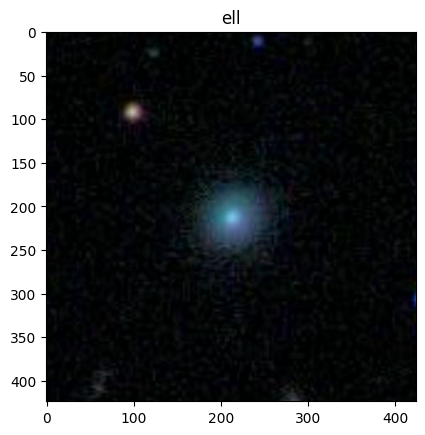

In [25]:
pl.imshow(ims[0])
pl.title(training_labels2.columns[np.argmax(training_labels2.iloc[0])])

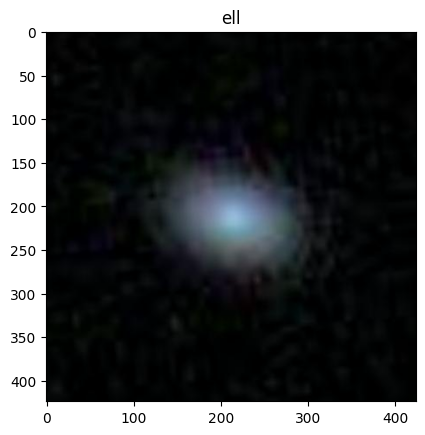

In [26]:
pl.imshow(ims[2])
pl.title(training_labels2.columns[np.argmax(training_labels2.iloc[2])]);

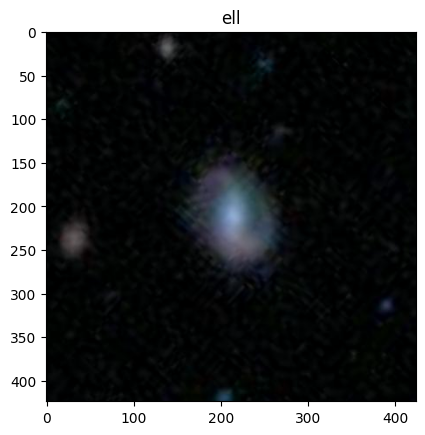

In [27]:
pl.imshow(ims[10])
pl.title(training_labels2.columns[np.argmax(training_labels2.iloc[10])]);

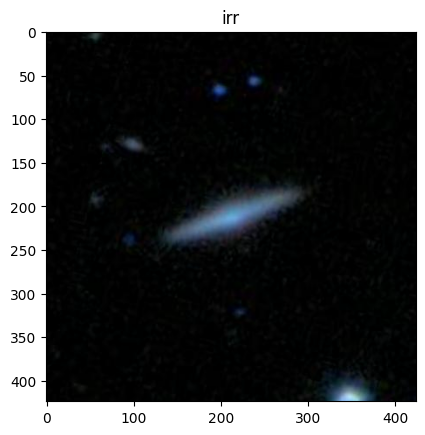

In [28]:
pl.imshow(ims[6])
pl.title(training_labels2.columns[np.argmax(training_labels2.iloc[6])]);

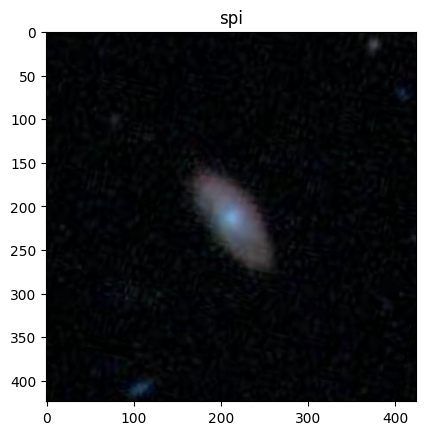

In [29]:
pl.imshow(ims[8])
pl.title(training_labels2.columns[np.argmax(training_labels2.iloc[8])]);

lots of ellipiticals..... and some label noise, see ims[10]...

In [33]:
np.unique(np.argmax(training_labels2[:1000].values, axis=1),  return_counts=True)

(array([0, 1, 2, 3]), array([  1,  46, 891,  62]))

DOWNSAMPLE THE IMAGES


split a 1000 galaxies dataset into train-test with a proportion of 2-1. Note that 1000 object is a critically small dataset for DNN!

In [34]:
y = training_labels2.iloc[:1000].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(ims, y, test_size=0.33,
                                                    random_state=42)

In [36]:
X_train.shape

(670, 212, 212, 3)

In [37]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]
input_shape = X_train.shape[1:]


In [38]:
X_train.shape

(670, 212, 212, 3)

In [39]:
#minmax the quick way
X_train = X_train / 255.0
X_test = X_test / 255.0


In [40]:
# lets set some parameters. Batch size is very important!
batch_size = 24
num_classes = 4
epochs = 50
input_shape, X_train.dtype, X_train.max(), X_train.min()

((212, 212, 3), dtype('float64'), 1.0, 0.0)

In [41]:
y_train.shape

(670, 4)

In [42]:
# Set Optimizer
opt = Adam(learning_rate=0.001)

In [50]:
#build the model
input_layer = keras.layers.Input(shape = input_shape)
x = Conv2D(32,(3,3), activation = "relu")(input_layer) #32 the sliding windows, 3,3 the size of window
x = Conv2D(64, (3,3), activation = "relu")(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.6)(x)
x = Flatten()(x)
x = Dense(128, activation ="relu")(x)
x = Dropout(0.4)(x)

outputs = Dense(4, activation = "softmax")(x)
model = keras.Model(input_layer, outputs)

#here you also need to chose your loss function! what kind of problem is this?
# what kind fo variables?

In [52]:
model.build(input_shape)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 212, 212, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 210, 210, 32)      896       
                                                                 
 conv2d_12 (Conv2D)          (None, 208, 208, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 104, 104, 64)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 104, 104, 64)      0         
                                                                 
 flatten_3 (Flatten)         (None, 692224)            0         
                                                           

In [56]:
model.compile( optimizer = opt, loss ="mse", metrics = "accuracy",)

In [57]:
history = model.fit(x = X_train, y = y_train, batch_size = 24, epochs = 5, verbose= 1, validation_split=0.1,) # include batch size, epochs, optimizer...

Epoch 1/5
26/26 [==============================] - 4s 142ms/step - loss: 0.0666 - accuracy: 0.8823 - val_loss: 0.0645 - val_accuracy: 0.8507
Epoch 2/5
26/26 [==============================] - 3s 128ms/step - loss: 0.0666 - accuracy: 0.8823 - val_loss: 0.0645 - val_accuracy: 0.8507
Epoch 3/5
26/26 [==============================] - 3s 128ms/step - loss: 0.0666 - accuracy: 0.8823 - val_loss: 0.0645 - val_accuracy: 0.8507
Epoch 4/5
26/26 [==============================] - 3s 130ms/step - loss: 0.0666 - accuracy: 0.8823 - val_loss: 0.0645 - val_accuracy: 0.8507
Epoch 5/5
26/26 [==============================] - 4s 151ms/step - loss: 0.0666 - accuracy: 0.8823 - val_loss: 0.0645 - val_accuracy: 0.8507


the loss goes up..... why do you think? what are the possible problems you see in this model?

Rebalancing data and turning probabilistic labels into classes

In [58]:
from imblearn.over_sampling import SMOTE

In [59]:
y_labels = np.argmax(y_train, axis=1)
np.unique(y_labels, return_counts=True) #EXTREME CLASS IMBALANCE!! thats why the loss goes up

(array([0, 1, 2, 3]), array([  1,  34, 589,  46]))

In [60]:
X_train_remove = X_train[~(y_labels==0)] #remove class of one, no hope to learn it
y_train_remove = y_train[~(y_labels==0)]
y_labels = y_labels[~(y_labels==0)]

In [61]:
#turn class label into one-hot encoded
y_train_onehot = np.zeros_like(y_train_remove)
for i,j in enumerate(np.argmax(y_train_remove, axis=1)):
  y_train_onehot[i,j] = 1
y_train_onehot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [62]:
original_shape = X_train_remove.shape #reshape to use SMOT
arr = X_train_remove.reshape(X_train_remove.shape[0], np.prod(X_train_remove.shape[1:]))
arr.shape

(669, 134832)

SMOTE oversamples or downsamples data based on preferred proportions. See manual

In [ ]:
from imblearn.over_sampling import SMOTE
SMOTE?

In [ ]:
smt = SMOTE(REPLACEME)
np.unique(y_smt, return_counts=True)

(array([1, 2, 3]), array([589, 589, 589]))

In [ ]:
#reshape the data to be image shaped
new_shape = [X_smt.shape[0]]
new_shape += [i for i in original_shape[1:]]
new_shape
X_smt = X_smt.reshape(new_shape)

now we have a ton of copies of the same data... lets at least rotate them, a simple augmentation methods

In [ ]:
for i in range(len(X_smt)):
  X_smt[i] = np.rot90(X_smt[i], np.random.randint(0, 4))

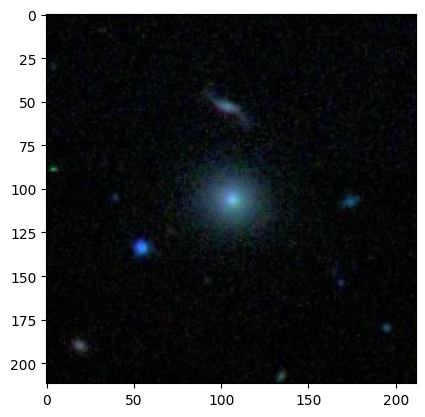

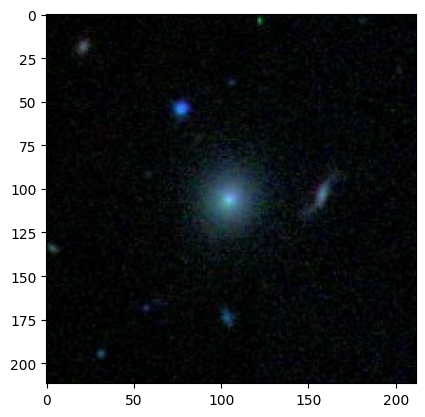

In [ ]:
i = 0
pl.imshow(X_smt[i])
pl.show()
pl.imshow(np.rot90(X_smt[i], np.random.randint(0, 4)))

In [ ]:
enc = preprocessing.OneHotEncoder().fit(y_smt.reshape(-1, 1))
y_onehot = enc.transform(y_smt.reshape(-1,1)).toarray().astype(int)

y_onehot

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
#callbacks
patience = EarlyStopping(patience=5) #stops running if metric does not improve for 5 epochs in a row
filepath = "galcheckpoints"
checkpointpath = filepath + "/cnn-improvement-{epoch:02d}-{loss:.4f}.hd5"
checkpoint = ModelCheckpoint(checkpointpath, monitor='loss', verbose=1,
                             save_best_only=True, mode='min') # saves intermediate weights at each epoch (for the best batch output)

In [ ]:
# Garbage Collector - use it like gc.collect() TO SAVE RAM
import gc
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
model = REPLAPCEME

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 203, 203, 32)      9632      
                                                                 
 conv2d_7 (Conv2D)           (None, 201, 201, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 flatten_3 (Flatten)         (None, 640000)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               81920128  
                                                      

# Important (for the exam)
# RAM:
 monitor your RAM (to the right).

 If the model is comsuming RAM increasingly one epoch after another makse sure you use the GarbageCollectorCallback https://stackoverflow.com/questions/61188185/how-to-free-memory-in-colab

 If the first epoch already requires too much RAM decrease the batch size and the size of your data (remember when we subsampled the images??)

# Computational resources

If you use ANN, remember to run GPUs

If your loss is not going down for several epochs (like in the earlier example) dont waste time, figure out what is wrong and fix it. But careful: learning may not start immediatelyl (tho it generally does with batches)

Your model may stall: look if collab says "You currently have zero compute resources". If you do.... just be patient

Save intermediate training stages (with the checkpoint callback). That way you can load them and restart training from there.  https://www.tensorflow.org/tutorials/keras/save_and_load

Note that you can restart training in the same session and the model will "hot start": start from the last set of weights. That means it will not restart learning from zero. This may be a good idea, for example to change learning rate. But remember to save the history every time you restart, so you can have a comprehensive sense of what you learned when. Same if load a model from a checkpoint.

Do not build a large model or run the model for many epochs from the start! This **will** cause issues: your first draft will almost certainly have some bug or poor choices. Test on small samples and short learning. Adjust model. Then when it looks good run for as long as needed

If your loss is not going down for several epochs (like in the earlier example) dont waste time, figure out what is wrong and fix it. But careful: learning may not start immediatelyl (tho it generally does with batches)

Use the EarlyStoppinc callback: this will stop the training if the model has stopped learning for a while.  The patience parameter defines how many epochs without improving and what is a minimum amount of improving you require to keep running. https://stackoverflow.com/questions/45028582/keras-earlystopping-patience-parameter. This does not mean your model has really finished learning.

- If your loss is noise restart with decreased learning rate

- If you are still improving but by very little amounts restart with increased the lerarning reate

In [ ]:
# you can skip this and load the saved model
history = model.fit(REPLACEME)

Epoch 1/50
59/59 [==============================] - 496s 8s/step - loss: 1.3011 - accuracy: 0.4699 - val_loss: 1.4239 - val_accuracy: 0.0000e+00
Epoch 2/50
59/59 [==============================] - 507s 9s/step - loss: 0.9464 - accuracy: 0.5796 - val_loss: 1.6226 - val_accuracy: 0.0028
Epoch 3/50
59/59 [==============================] - 537s 9s/step - loss: 0.8138 - accuracy: 0.6695 - val_loss: 1.6455 - val_accuracy: 0.0056
Epoch 4/50
41/59 [===================>..........] - ETA: 2:30 - loss: 0.5999 - accuracy: 0.7378

In [ ]:
# example of saving the trained model
# Loads the weights
latest = tf.train.latest_checkpoint(filepath)
latest

model.load_weights(latest)

# Evaluate the model
loss, acc = model.evaluate(X_test, y_test_onehot, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
pl.plot(history.history['loss'])
pl.ylabel("loss")
pl.xlabel("epoch")

In [ ]:
pl.plot(history.history['accuracy'])
pl.ylabel("accuracy")
pl.xlabel("epoch")

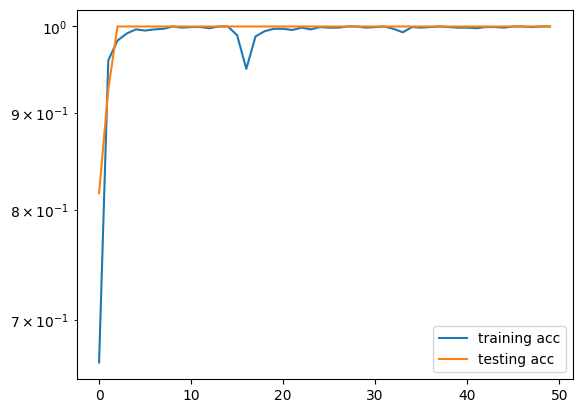

In [ ]:
pl.plot(history.history['accuracy'], label="training acc")
pl.plot(history.history['val_accuracy'], label="testing acc")
pl.ylabel("accuracy (log)")
pl.xlabel("epoch")
pl.yscale('log')
pl.legend()

In [ ]:
y_test_onehot = np.zeros_like(y_test)
for i,j in enumerate(np.argmax(y_test[:, 1:], axis=1)):
  y_test_onehot[i,j] = 1
y_test_onehot
model.predict(X_test[:10]) #but note that we did not rebalance the test set!

1/1 [==============================] - 0s 22ms/step


array([[9.5154081e-19, 1.0000000e+00, 6.6227248e-22],
       [6.0265265e-08, 9.9999988e-01, 3.0564302e-13],
       [2.8635514e-12, 1.0000000e+00, 3.9051532e-30],
       [6.2208447e-11, 1.0000000e+00, 4.7003460e-11],
       [9.7817943e-12, 1.0000000e+00, 7.8725478e-14],
       [1.7444378e-12, 1.0000000e+00, 1.7111164e-18],
       [6.0791677e-13, 1.0000000e+00, 3.4964715e-16],
       [2.5462655e-06, 9.9999750e-01, 4.2084070e-10],
       [8.7267256e-21, 1.0000000e+00, 6.7087786e-20],
       [1.2174604e-09, 1.0000000e+00, 4.6034260e-10]], dtype=float32)

In [ ]:
np.argmax(y_test_onehot, axis=1)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,

In [ ]:
np.argmax(model.predict(X_test), axis=1)

11/11 [==============================] - 0s 41ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,

In [ ]:
# Model performance summary: DISCUSS!
print(classification_report(np.argmax(y_test_onehot, axis=1),
                      np.argmax(model.predict(X_test), axis=1)))